In [21]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import timeit
import algorithms.geo_utils as geo_utils
from IPython.core.debugger import set_trace
%matplotlib inline
def string_to_array(string):
    if string == '':
        return list()
    return eval(string)

CITY="madison"


In [22]:
df_checkin=pd.read_csv("../data/checkin/"+CITY+".csv",converters={'categories':string_to_array})
df_checkin['date']=pd.to_datetime(df_checkin['date'])
# users=df_checkin['user_id'].drop_duplicates().reset_index(drop=True)
# num_users=len(users)
df_checkin.set_index("user_id",inplace=True)
df_checkin.head()

,business_id,date,latitude,longitude,categories,subarea_id
user_id,,,,,,
MB7Z80PJxNyQM7keDpR2XQ,br1uQbc3YU5jCpYi46nIgQ,2018-04-04 00:09:03,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0
4HwS2oCVQ1-f_kzHCv5X3A,br1uQbc3YU5jCpYi46nIgQ,2018-02-16 20:40:41,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0
OLBH2Ds1wllrzpHlyojzJQ,br1uQbc3YU5jCpYi46nIgQ,2018-04-12 11:31:03,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0
wd3xoNaDLib8dhQ7BxUl6g,br1uQbc3YU5jCpYi46nIgQ,2018-03-07 14:08:41,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0
4HwS2oCVQ1-f_kzHCv5X3A,br1uQbc3YU5jCpYi46nIgQ,2018-02-16 20:48:49,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0


In [23]:
df_poi=pd.read_csv("../data/poi/"+CITY+".csv",converters={'categories':string_to_array})
df_poi=df_poi.set_index("business_id")

### Centroide

In [24]:
df_checkin=df_checkin.reset_index().drop_duplicates(subset=['user_id','business_id']).set_index('user_id')

In [25]:
df_user_dist_mean=pd.DataFrame(columns=['user_id','dist_mean','subareas'])
for user_id in df_checkin.index.drop_duplicates():
    subareas_id=set()
    df_user_checkin=df_checkin.loc[user_id]
    latitude,longitude=df_user_checkin[['latitude','longitude']].mean()
    dist_ac=0
    for index,row in df_user_checkin[['latitude','longitude','subarea_id']].iterrows():
        dist=geo_utils.haversine(latitude,longitude,row.latitude,row.longitude)
        dist_ac+=dist
        subareas_id.add(row['subarea_id'])
    
    dist_mean=dist_ac/len(df_user_checkin)
    df_user_dist_mean=df_user_dist_mean.append({'user_id':user_id,'dist_mean':dist_mean,'subareas':len(subareas_id)},ignore_index=True)
df_user_dist_mean.head(2)

,user_id,dist_mean,subareas
0,MB7Z80PJxNyQM7keDpR2XQ,4.151365,21
1,4HwS2oCVQ1-f_kzHCv5X3A,1.643125,26


In [26]:
df_user_dist_mean.describe()

,dist_mean
count,1022.000000
mean,4.589336
std,1.777380
min,0.326515
25%,3.293402
50%,4.637066
75%,5.758750
max,10.729046


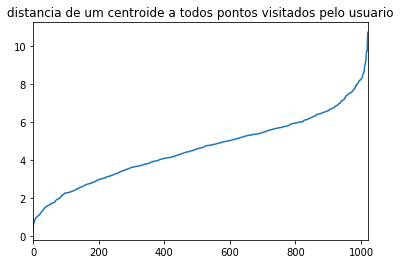

In [27]:
df_user_dist_mean['dist_mean'].sort_values().reset_index(drop=True).plot(title='distancia de um centroide a todos pontos visitados pelo usuario')

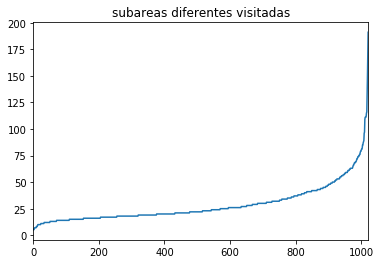

In [28]:
df_user_dist_mean['subareas'].sort_values().reset_index(drop=True).plot(title='subareas diferentes visitadas')

In [29]:
#df_user_dist_mean[['dist_mean','subareas']].sort_values(by='dist_mean').reset_index(drop=True).plot.bar()

In [30]:
tmp=df_user_dist_mean[['dist_mean','subareas']].sort_values(by='dist_mean').reset_index(drop=True)

tmp.head(2)

,dist_mean,subareas
0,0.326515,5
1,0.645192,8


In [76]:
df_group_mean=pd.DataFrame(columns=['subareas'])
i=0
for subareas in tmp['subareas']:
    if i % 50==49:
        df_group_mean=df_group_mean.append({'user_id':user_id,'dist_mean':dist_mean,'subareas':len(subareas_id)},ignore_index=True)
        
    i+=1

In [33]:
# correlação entre distancia e subareas
tmp['dist_mean'].corr(tmp['subareas'].apply(lambda x: np.float64(x)))

0.2589552777649776

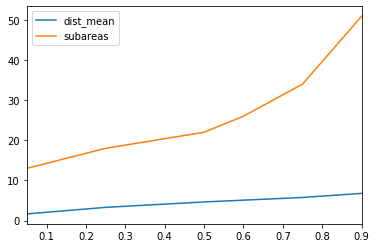

In [12]:
quantile_argument=[0.05, 0.25, 0.5, 0.6,0.75,0.9]
tmp.quantile(quantile_argument)
tmp['subareas'].quantile(quantile_argument)
pd.concat([tmp.quantile(quantile_argument),tmp['subareas'].quantile([0.05, 0.25, 0.5, 0.6,0.75,0.9])],axis=1).plot()

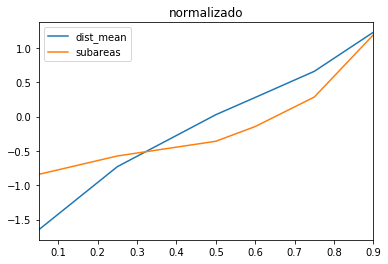

In [13]:
tmp=(tmp-tmp.mean())/tmp.std()
tmp.quantile(quantile_argument)
tmp['subareas'].quantile(quantile_argument)
pd.concat([tmp.quantile(quantile_argument),tmp['subareas'].quantile([0.05, 0.25, 0.5, 0.6,0.75,0.9])],axis=1).plot(title='normalizado')

Text(0.5, 1.0, 'Kernel Density Estimate usando Gaussian kernels, Distância média.')

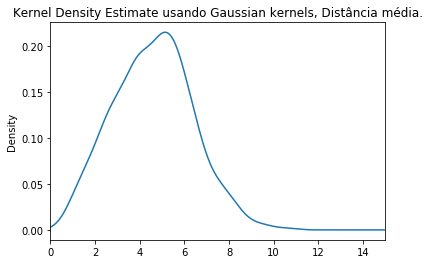

In [54]:
plt=tmp['dist_mean'].plot.kde()
plt.set_xlim(0,15)
plt.set_title("Kernel Density Estimate usando Gaussian kernels, Distância média.")

(0, 100)

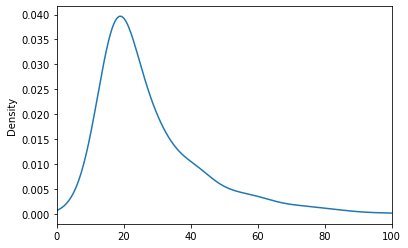

In [55]:
plt=tmp['subareas'].plot.kde()
plt.set_xlim(0,100)